In [18]:
# General Imports
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

from sklearn.metrics import confusion_matrix

In [19]:
# Neural Network imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam

In [20]:
# Image augmentation importrs
from tensorflow.keras.utils import load_img
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import RandomRotation
from tensorflow.keras.layers import RandomContrast
from tensorflow.keras.layers import RandomZoom
from tensorflow.keras.layers import RandomFlip
from tensorflow.keras.layers import RandomTranslation

In [21]:
# Training Model callbacks
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

Data Pre-processing

In [22]:
def get_data_labels(directory, shuffle=True, random_state=0):
    from sklearn.utils import shuffle
    data_path = []
    data_index = []
    label_dict = {label: index for index, label in enumerate(sorted(os.listdir(directory)))}

    for label, index in label_dict.items():
        label_dir = os.path.join(directory, label)
        for image in os.listdir(label_dir):
            image_path = os.path.join(label_dir, image)
            data_path.append(image_path)
            data_index.append(index)

    if shuffle:
        data_path, data_index = shuffle(data_path, data_index, random_state=random_state)

    return data_path, data_index

def parse_function(filename, label, image_size, n_channels):
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, n_channels)
    image = tf.image.resize(image, image_size)
    return image, label

def get_dataset(paths, labels, image_size, n_channels=1, num_classes=4, batch_size=32):
    path_ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    image_label_ds = path_ds.map(lambda path, label: parse_function(path, label, image_size, n_channels),
                                 num_parallel_calls=tf.data.AUTOTUNE)
    return image_label_ds.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

In [23]:
import os
import tensorflow as tf


train_paths = 'BT_50/Training'
test_paths = 'BT_50/Testing'


train_image_paths, train_index = get_data_labels(train_paths)


test_image_paths, test_index = get_data_labels(test_paths)


batch_size = 32
image_dim = (168, 168)
train_ds = get_dataset(train_image_paths, train_index, image_dim, n_channels=1, num_classes=4, batch_size=batch_size)
test_ds = get_dataset(test_image_paths, test_index, image_dim, n_channels=1, num_classes=4, batch_size=batch_size)

In [24]:
class_mappings = {'Glioma': 0, 'Meninigioma': 1, 'Notumor': 2, 'Pituitary': 3}
inv_class_mappings = {v: k for k, v in class_mappings.items()}
class_names = list(class_mappings.keys())

In [25]:
# Printing traing and testing sample sizes
print('Training')
print(f'Number of Paths: {len(train_paths)}')
print(f'Number of Labels: {len(train_index)}')
print('\nTesting')
print(f'Number of Paths: {len(test_paths)}')
print(f'Number of Labels: {len(test_index)}')

Training
Number of Paths: 14
Number of Labels: 2640

Testing
Number of Paths: 13
Number of Labels: 600


In [26]:
# Output to show datasets
print(f"\nTraining dataset: {train_ds}")
print(f"\nTesting dataset: {test_ds}")


Training dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 168, 168, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

Testing dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 168, 168, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


Training Setup

In [27]:
# Dta augmentation sequential model
data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.02, fill_mode='constant'),
    RandomContrast(0.1),
    RandomZoom(height_factor=0.01, width_factor=0.05),
    RandomTranslation(height_factor=0.0015, width_factor=0.0015, fill_mode='constant'),
])

# Training augmentation and nornalization
def preprocess_train(image, label):
    # Apply data augmentation and Normalize
    image = data_augmentation(image) / 255.0
    return image, label




# For test dataset only appying normalization
def preprocess_test(image, label):
    return image / 255.0, label




# Apply transformation to training and testing datasets
train_ds_preprocessed = train_ds.map(preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_preprocessed = test_ds.map(preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)

In [28]:
# Classes and Image shape: height, width, grayscale
num_classes = len(class_mappings.keys())
image_shape = (image_dim[0], image_dim[1], 1)

# Training epochs and batch size
epochs = 50
print(f'Number of Classes: {num_classes}')
print(f'Image shape: {image_shape}')
print(f'Epochs: {epochs}')
print(f'Batch size: {batch_size}')

def encode_labels(image, label):
    return image, tf.one_hot(label, depth=num_classes)

train_ds_preprocessed = train_ds_preprocessed.map(encode_labels, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_preprocessed = test_ds_preprocessed.map(encode_labels, num_parallel_calls=tf.data.AUTOTUNE)

Number of Classes: 4
Image shape: (168, 168, 1)
Epochs: 50
Batch size: 32


CNN Architecture

In [29]:
# Building model
model = Sequential([
    # Input tensor shape
    Input(shape=image_shape),

    # Convolutional layer 1
    Conv2D(64, (5, 5), activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),

    # Convolutional layer 2
    Conv2D(64, (5, 5), activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),

    # Convolutional layer 3
    Conv2D(128, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),

    # Convolutional layer 4
    Conv2D(128, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),

    # Dense layers
    Dense(512, activation="relu"),
    Dense(num_classes, activation="softmax")
])

# Model summary
model.summary()

# COompilng model with Adam optimizer
optimizer = Adam(learning_rate=0.001, beta_1=0.85, beta_2=0.9925)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics= ['accuracy'])

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 164, 164, 64)        │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 50, 50, 64)          │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 13, 13, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 3, 3, 128)           │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 565,700 (2.16 MB)

 Trainable params: 565,700 (2.16 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
# Custom callback for reducing learning rate at accuracy values
class ReduceLROnMultipleAccuracies(tf.keras.callbacks.Callback):
    def __init__(self, thresholds, factor, monitor='val_accuracy', verbose=1):
        super(ReduceLROnMultipleAccuracies, self).__init__()
        self.thresholds = thresholds  # List of accuracy thresholds
        self.factor = factor  # Factor to reduce the learning rate
        self.monitor = monitor
        self.verbose = verbose
        self.thresholds_reached = [False] * len(thresholds)  # Track each threshold

    def on_epoch_end(self, epoch, logs=None):
        current_accuracy = logs.get(self.monitor)
        for i, threshold in enumerate(self.thresholds):
            if current_accuracy >= threshold and not self.thresholds_reached[i]:
                optimizer = self.model.optimizer
                old_lr = optimizer.learning_rate.numpy()
                new_lr = old_lr * self.factor
                optimizer.learning_rate.assign(new_lr)
                self.thresholds_reached[i] = True  # Mark this threshold as reached
                if self.verbose > 0:
                    print(f"\nEpoch {epoch+1}: {self.monitor} reached {threshold}. Reducing learning rate from {old_lr} to {new_lr}.")

# Try a custom callback
thresholds = [0.96, 0.99, 0.9935]
lr_callback = ReduceLROnMultipleAccuracies(thresholds=thresholds, factor=0.75, monitor='val_accuracy', verbose=False)

In [31]:
# Callbacks for improved covergence of gradient and best test accuracy
model_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, min_lr=1e-4, patience=4, verbose=False)
model_mc = ModelCheckpoint('model.keras', monitor='val_accuracy', mode='max', save_best_only=True, verbose=False)

# Training the model
history = model.fit(
    train_ds_preprocessed,
    epochs=epochs,
    validation_data=test_ds_preprocessed,
    callbacks=[model_rlr, model_mc],
    verbose=True
)

Epoch 1/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 14s 117ms/step - accuracy: 0.3711 - loss: 1.2315 - val_accuracy: 0.5717 - val_loss: 1.1271 - learning_rate: 0.0010
Epoch 2/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 19s 125ms/step - accuracy: 0.7030 - loss: 0.7211 - val_accuracy: 0.7117 - val_loss: 0.7145 - learning_rate: 0.0010
Epoch 3/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step - accuracy: 0.7629 - loss: 0.5520 - val_accuracy: 0.8250 - val_loss: 0.5477 - learning_rate: 0.0010
Epoch 4/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - accuracy: 0.8304 - loss: 0.4136 - val_accuracy: 0.8567 - val_loss: 0.4445 - learning_rate: 0.0010
Epoch 5/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - accuracy: 0.8591 - loss: 0.3366 - val_accuracy: 0.8667 - val_loss: 0.4467 - learning_rate: 0.0010
Epoch 6/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - accuracy: 0.8924 - loss: 0.2791 - val_accuracy: 0.8617 - val_loss: 0.5340 - learning_rate: 0.0010
Epoch 7/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - accuracy: 0.9131 - loss: 0.2229 - 

### Model Evaluation

In [32]:
test_loss, test_acc = model.evaluate(test_ds_preprocessed)
print(f"Test accuracy: {test_acc*100:0.4f}%")

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9270 - loss: 0.6214
Test accuracy: 94.3333%


In [33]:
from sklearn.metrics import classification_report

y_pred = model.predict(test_ds_preprocessed)
y_pred_classes = np.argmax(y_pred, axis=1)
# Get true labels as class indices instead of one-hot encoded vectors
true_labels = np.concatenate([np.argmax(y.numpy(), axis=-1) for x, y in test_ds_preprocessed], axis=0)
print(classification_report(true_labels, y_pred_classes))

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step
              precision    recall  f1-score   support

           0       0.92      0.95      0.93       150
           1       0.94      0.87      0.90       150
           2       0.96      0.98      0.97       150
           3       0.96      0.97      0.96       150

    accuracy                           0.94       600
   macro avg       0.94      0.94      0.94       600
weighted avg       0.94      0.94      0.94       600



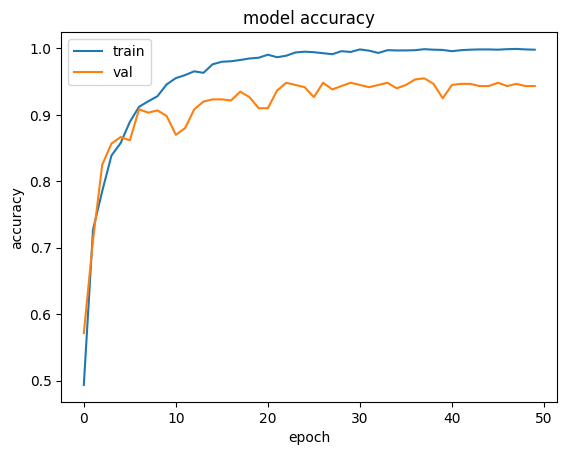

In [34]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

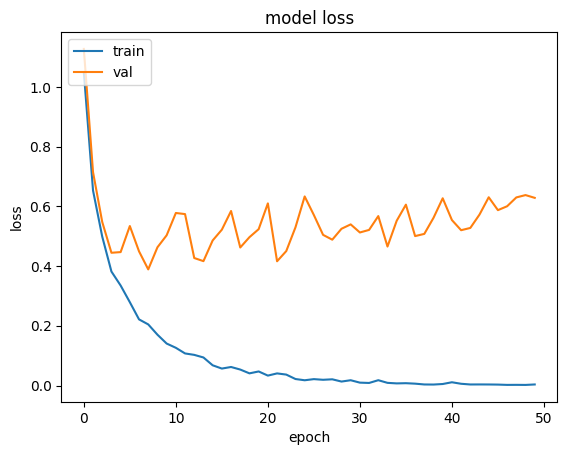

In [35]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

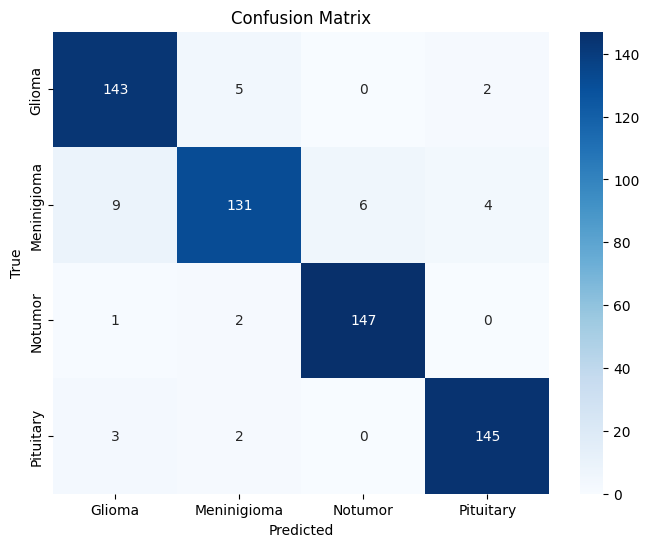

In [36]:
# prompt: I want confusion matrix

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# prompt: write a program to predict on one image

import numpy as np
# Load the saved model
model = load_model('model.keras')  # Replace 'your_model.h5' with the actual path

# Function to predict on a single image
def predict_on_image(image_path):
    img = load_img(image_path, color_mode='grayscale', target_size=(168, 168))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize

    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)

    return predicted_class, prediction

# Example usage:
image_path_to_predict = 'Tr-pi_0021.jpg'  # Replace with your image path
predicted_class, prediction = predict_on_image(image_path_to_predict)

print(f"Predicted class index: {predicted_class}")
print(f"Prediction probabilities: {prediction}")

# Map the predicted class index to the class label
predicted_class_label = inv_class_mappings[predicted_class]
print(f"Predicted class label: {predicted_class_label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step
Predicted class index: 3
Prediction probabilities: [[2.7372141e-19 9.1810423e-14 2.6714243e-13 1.0000000e+00]]
Predicted class label: Pituitary


In [38]:
# prompt: save my model in .h5

model.save('SL_50_model_94_acc.keras')


In [39]:
!ls

BT_50  BT_50.zip  model.keras  sample_data  SL_50_model_94_acc.h5  SL_50_model_94_acc.keras
